<a href="https://colab.research.google.com/github/huseyincavusbi/Ensemble_Risk_Predictor/blob/main/Ensemble_Risk_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Welcome to Ensemble Risk Predictor
# https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset?resource=download
!git clone https://github.com/huseyincavusbi/Ensemble_Risk_Predictor
!pip install --upgrade setuptools wheel kagglehub==0.3.5 pandas==2.2.2 numpy==1.26.4 matplotlib==3.8.0 seaborn==0.13.2 scikit-learn==1.5.2 plotly==5.24.1 imbalanced-learn==0.12.4 joblib==1.4.2 google-generativeai==0.8.3 dotenv

fatal: destination path 'Ensemble_Risk_Predictor' already exists and is not an empty directory.
Files removed: 40
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os

# Download latest version
dataset_name = "alexteboul/heart-disease-health-indicators-dataset"
file_path = kagglehub.dataset_download(dataset_name)

print("Path to dataset directory:", file_path)

# List files in the downloaded directory
all_files = os.listdir(file_path)
print("Files in the directory:", all_files)

# Assuming the CSV file is named 'heart_disease_health_indicators_BRFSS2015.csv'
csv_file_name = 'heart_disease_health_indicators_BRFSS2015.csv'
csv_file_path = os.path.join(file_path, csv_file_name)

# Read the CSV file
try:
    df = pd.read_csv(csv_file_path)
    print(df.head())
    print('-' * 50)
    print(df.info())
    print('-' * 50)
    print(df.describe())
    print('-' * 50)
    print(df.shape)
except FileNotFoundError:
    print(f"Error: CSV file '{csv_file_name}' not found in the directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Path to dataset directory: /root/.cache/kagglehub/datasets/alexteboul/heart-disease-health-indicators-dataset/versions/3
Files in the directory: ['heart_disease_health_indicators_BRFSS2015.csv']
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0         

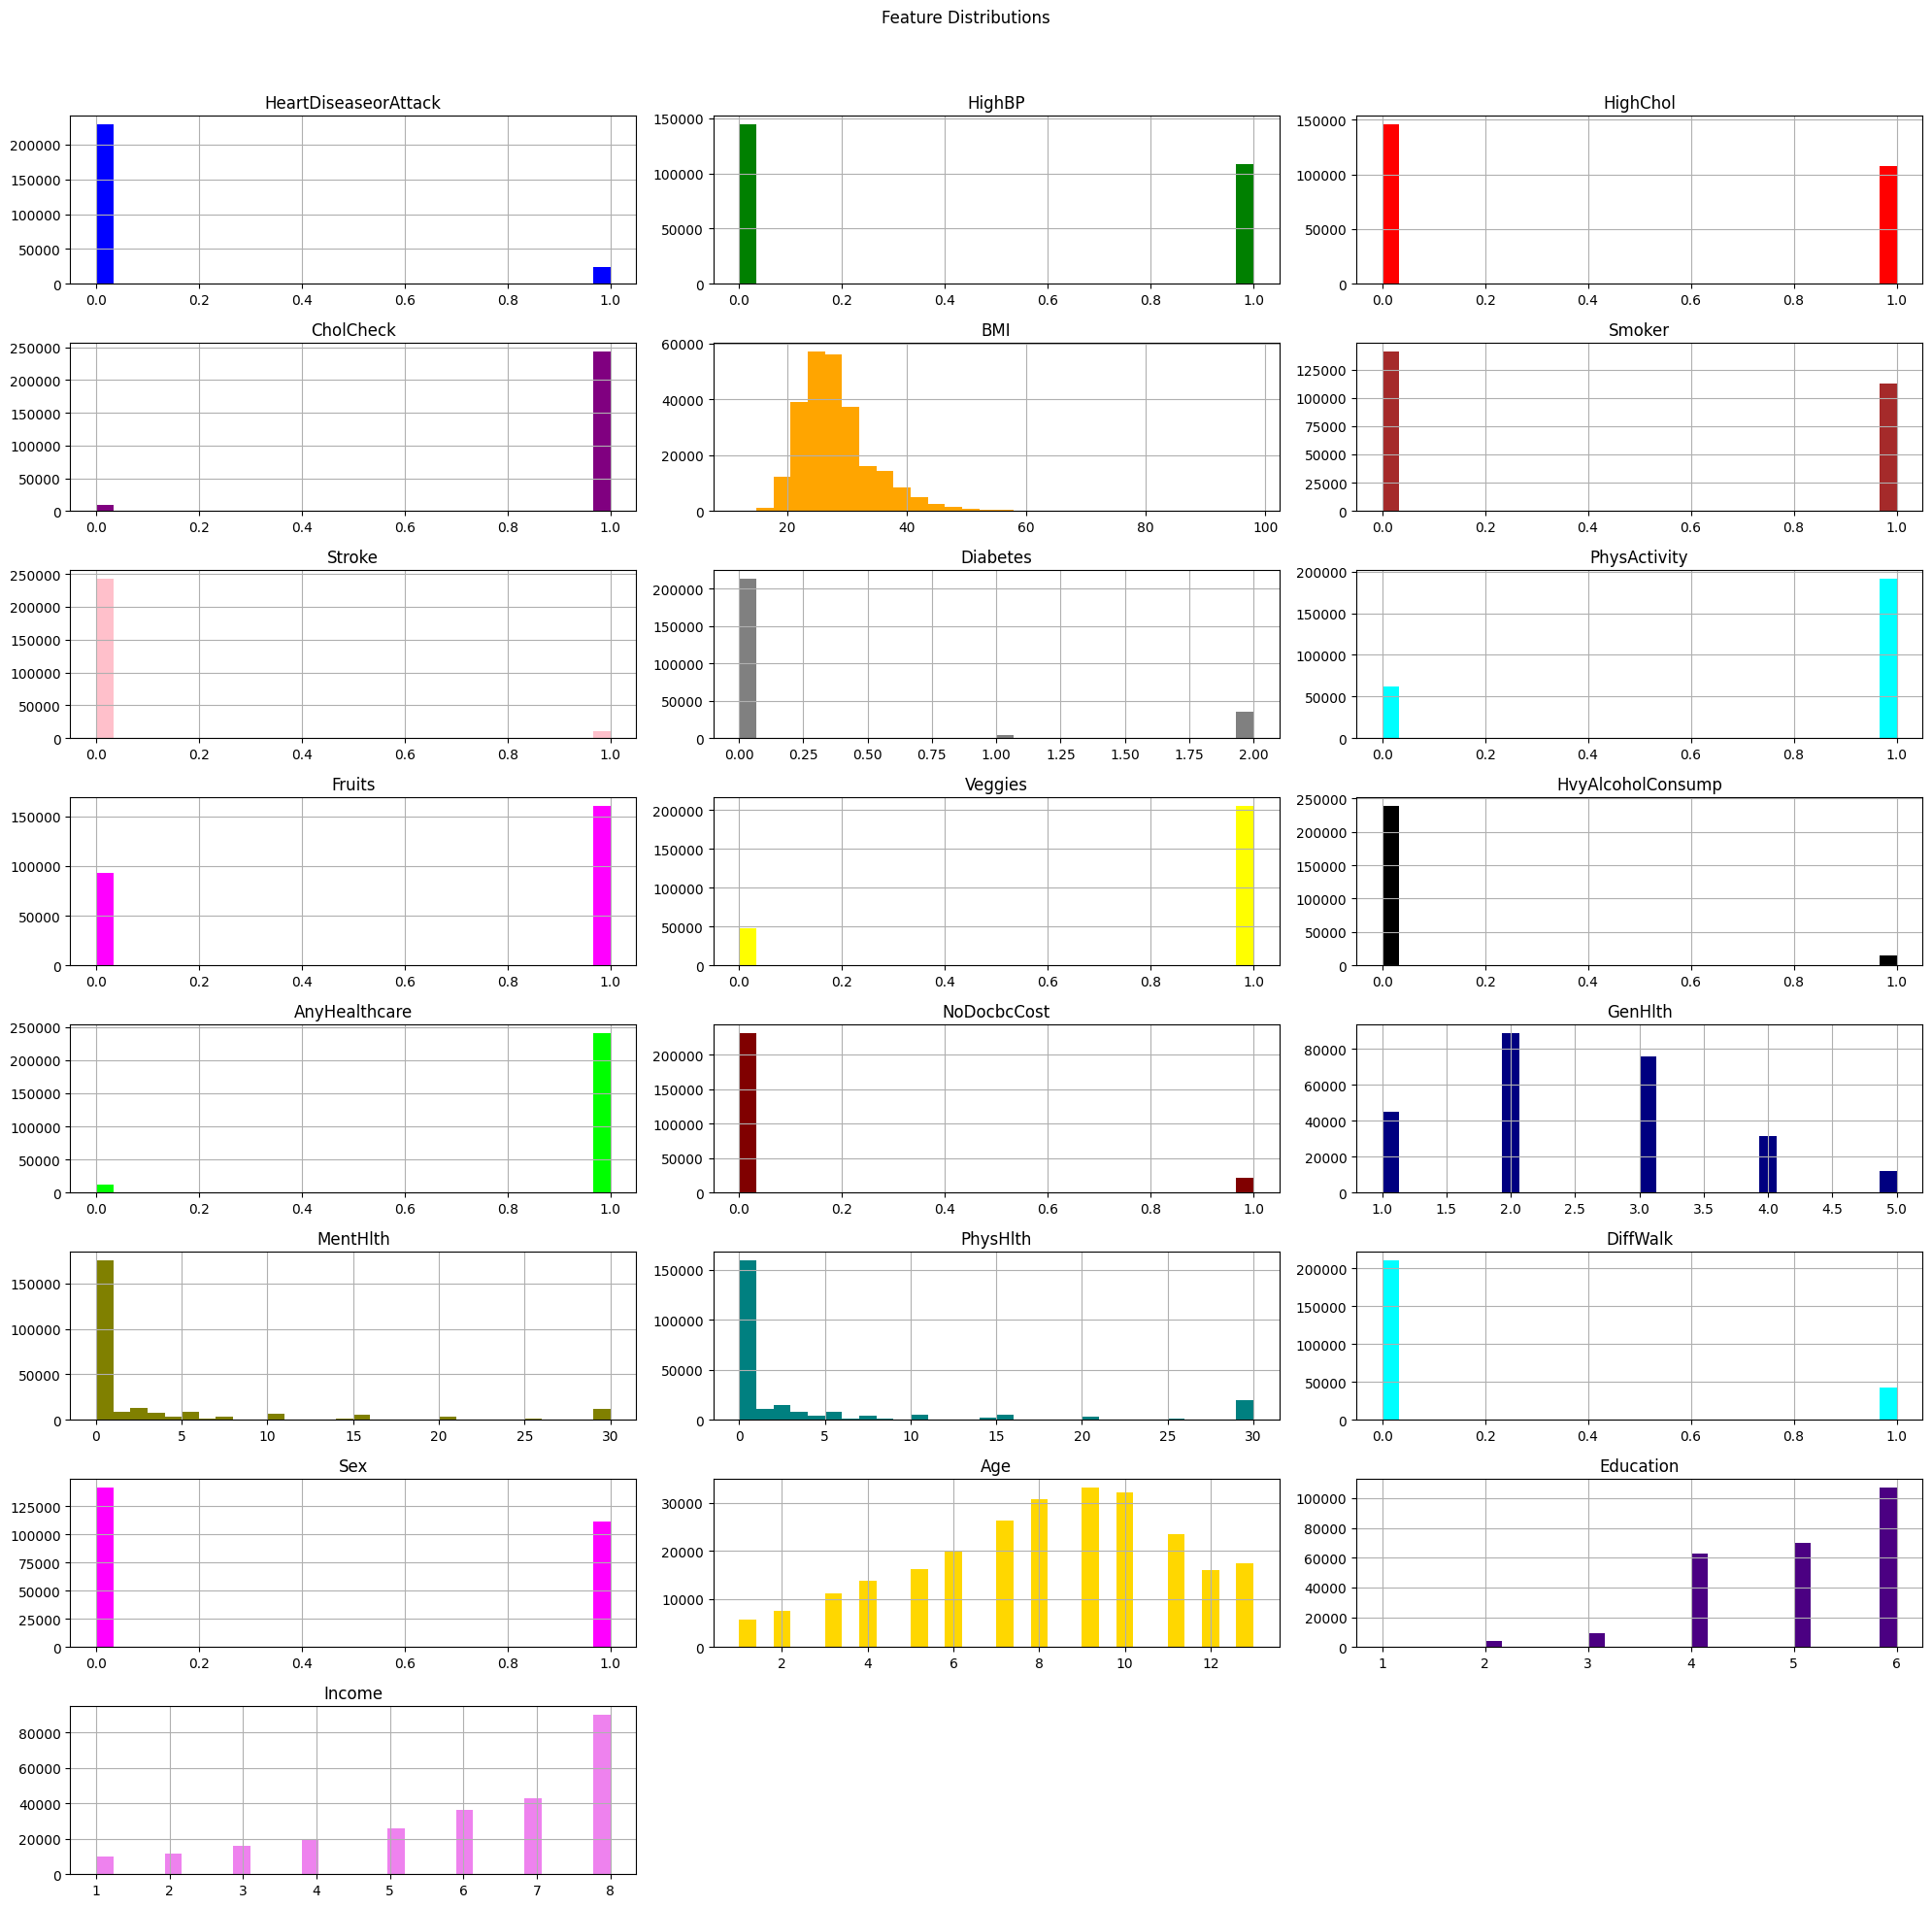

In [2]:
# Plotting the distribution of each feature with different colors
colors = [
    'blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta',
    'yellow', 'black', 'lime', 'maroon', 'navy', 'olive', 'teal', 'aqua', 'fuchsia', 'gold',
    'indigo', 'violet'
]

# Different colors
plt.figure(figsize=(20, 20))
for i, column in enumerate(df.columns):
    plt.subplot(len(df.columns) // 3 + 1, 3, i + 1)
    df[column].hist(bins=30, color=colors[i % len(colors)])
    plt.title(column)

plt.suptitle('Feature Distributions')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

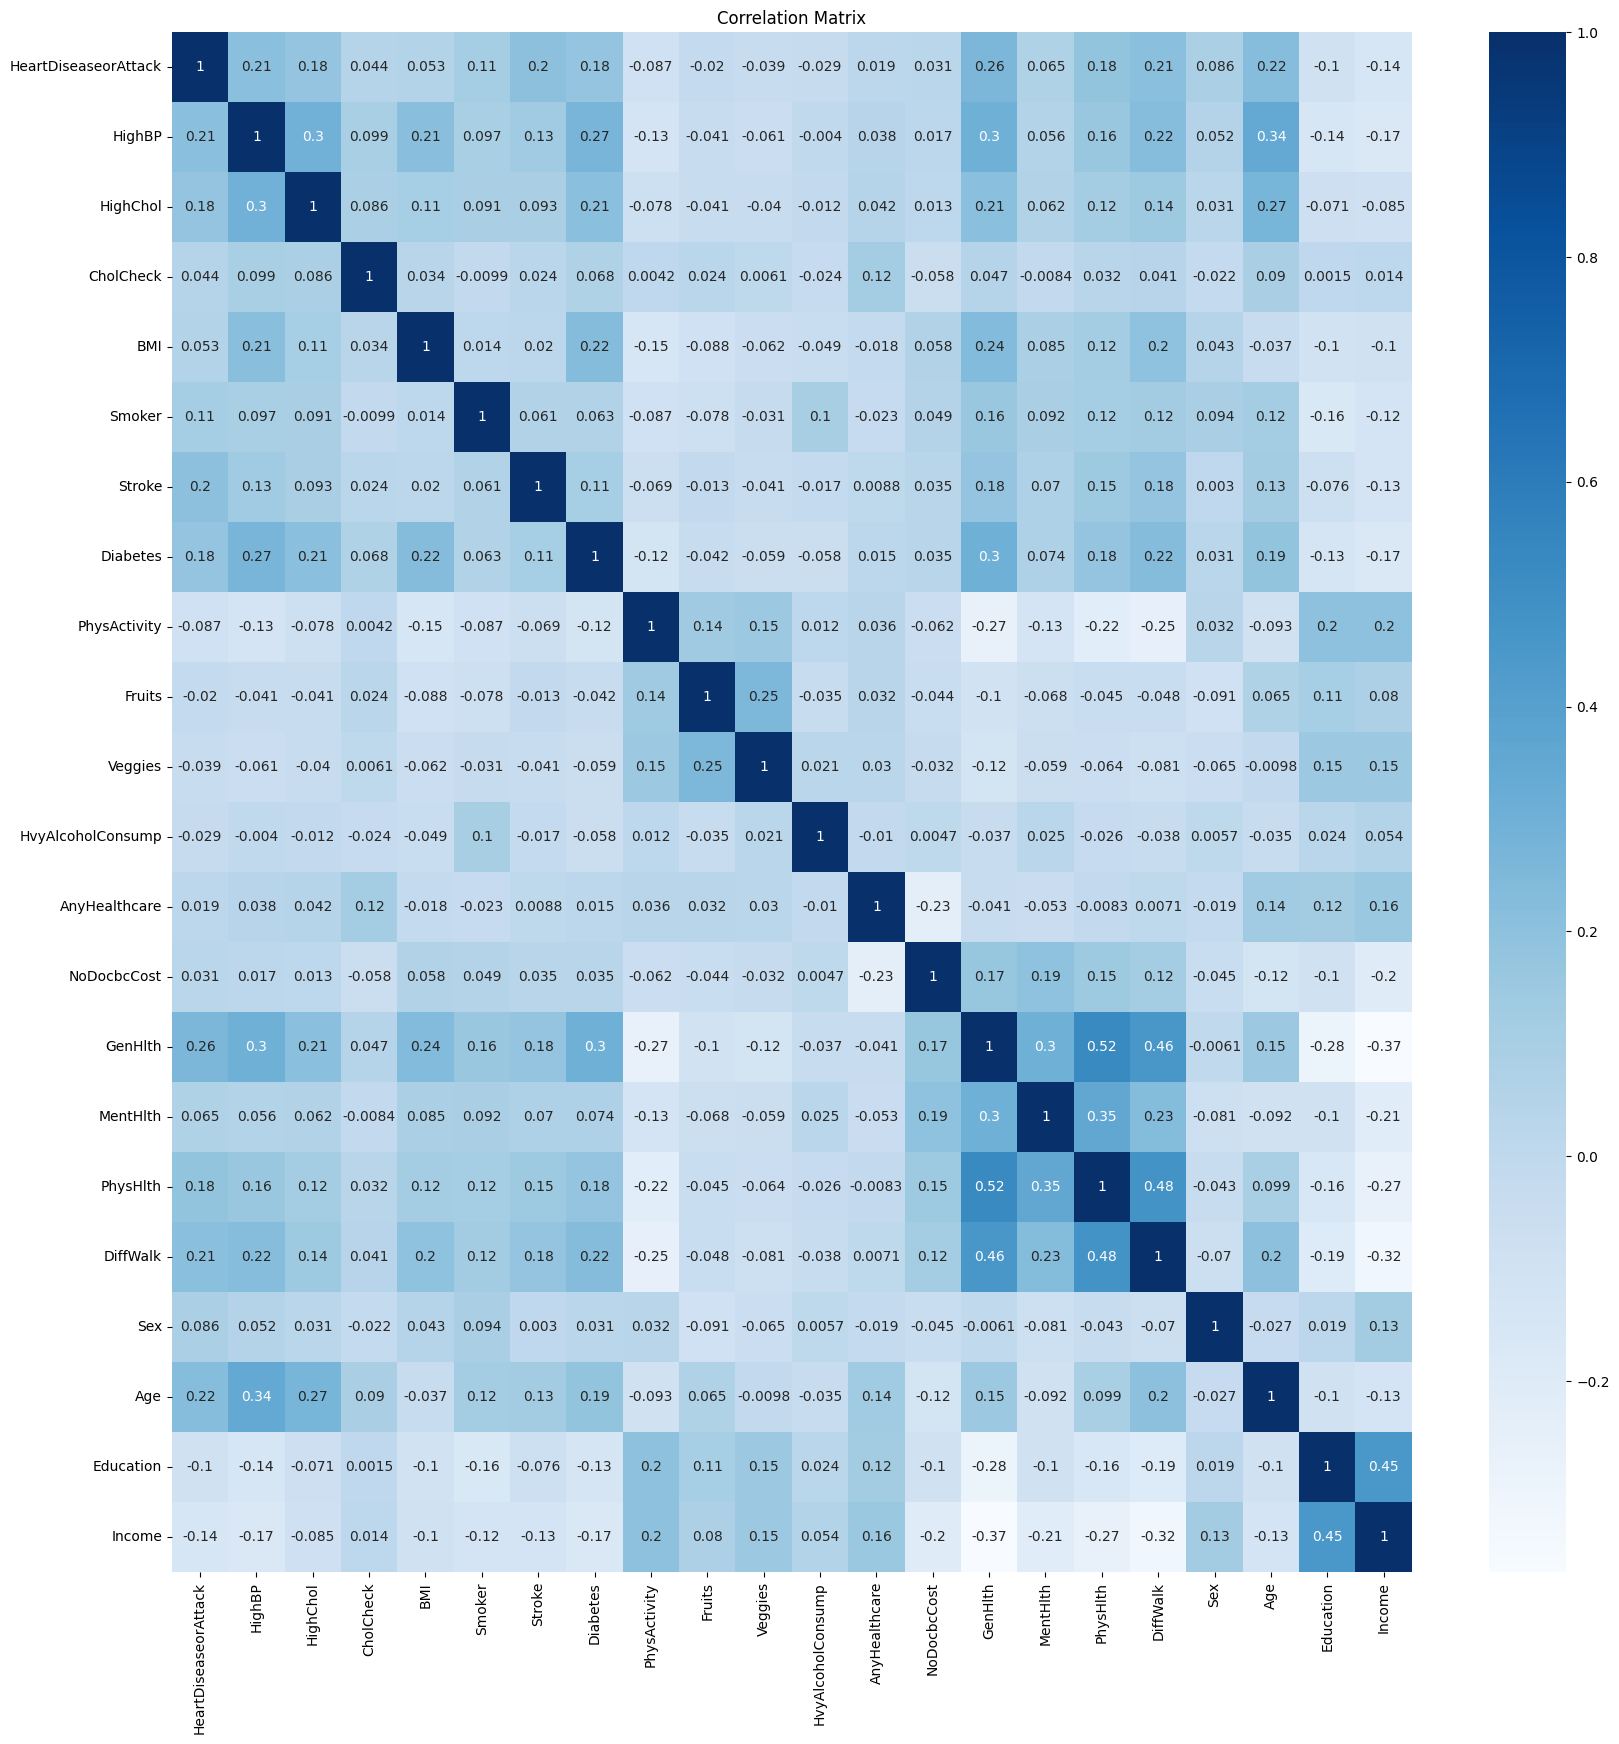

In [3]:
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap( df.corr(), annot=True, cmap='Blues')

plt.title('Correlation Matrix')
plt.show()

In [4]:
import plotly.express as px

# Visualizing a random subset
df['ID'] = range(1, len(df) + 1) # Creating a new column 'ID' with unique values to easily visualize random selection
cols = ['ID'] + [col for col in df.columns if col != 'ID']
df = df[cols]
df

random_subset = df.sample(n=10, random_state=42) # Randomly select 10 samples to visualize

features = [
    'ID', 'HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
     'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'AnyHealthcare', 'NoDocbcCost',
     'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
]

fig = px.scatter_matrix(
    random_subset,
    dimensions=features,
    color='HeartDiseaseorAttack',  # Color by 'HeartDiseaseorAttack'
    title='Scatter Matrix of Randomly Selected Participants',
    width=2400, height=2400
)

fig.show()

df = df.drop(columns=['ID']) # Removing intentionally created ID column to prevent future errors

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks

# Loading and Exploring the Dataset
data = pd.read_csv(csv_file_path)

print("First 5 rows of the dataset:")
print(data.head())

print("\nMissing values in each column:")
print(data.isnull().sum())

print("\nClass distribution:")
print(data['HeartDiseaseorAttack'].value_counts())

# Preprocessing the Data
# Separating features and target
X = data.drop(columns=['HeartDiseaseorAttack'])
y = data['HeartDiseaseorAttack']

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # stratifying by target class
)

First 5 rows of the dataset:
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  Diff

In [7]:
# Training Easy Ensemble Model
'''
If you want the model to make predictions, you do not need to train it again.
You can use the already trained model by running the cell below and entering input
or giving a csv in a format suitable for sample csvs.
'''
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Ignoring Future warnings for clear vision

import joblib
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    f1_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek

# Initializing the base estimator for RFE -recursive feature elimination, helped a lot in this dataset-
base_estimator = DecisionTreeClassifier(random_state=42)

# Defining the number of features to select
n_features_to_select = 10

# Initializing RFE
rfe = RFE(estimator=base_estimator, n_features_to_select=n_features_to_select)

# Fitting RFE on the entire original dataset *before* any cross-validation
rfe.fit(X, y)

# Getting the selected features
selected_features_mask = rfe.support_
selected_features = X.columns[selected_features_mask]
print(f"Selected features by RFE: {selected_features.tolist()}")

# Defining the specific parameters for RandomForestClassifier
rf_params = {
    'n_estimators': 25,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'criterion': 'entropy',
    'n_jobs': -1  # Use all available CPU cores for RandomForestClassifier
}

# Initializing StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics from each fold
accuracy_scores = []
roc_auc_scores = []
f1_scores = []
confusion_matrices = []
classification_reports = []

print("\n--- K-Fold Cross-Validation ---")

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    print(f"\nFold {fold+1}/{cv.get_n_splits()}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Selecting features based on pre-trained RFE
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Resampling the training data
    smt = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train_selected, y_train)

    # Initializing the model with specified parameters
    eec_model = EasyEnsembleClassifier(
        estimator=RandomForestClassifier(random_state=42, **rf_params),
        random_state=42,
        sampling_strategy='auto',
        replacement=True,
        n_jobs=-1
    )

    # Fitting the model
    eec_model.fit(X_train_resampled, y_train_resampled)

    # Making predictions on the test set
    y_pred = eec_model.predict(X_test_selected)
    y_pred_proba = eec_model.predict_proba(X_test_selected)[:, 1]

    # Evaluating the model on the test set
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Appending the evaluation metrics to the respective lists
    accuracy_scores.append(accuracy)
    roc_auc_scores.append(roc_auc)
    f1_scores.append(f1)
    confusion_matrices.append(cm)
    classification_reports.append(report)

    print("Fold Validation Classification Report:")
    print(report)

    print("Fold Validation Confusion Matrix:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Fold {fold+1} Confusion Matrix (Selected Features)')
    plt.show()
    print("-" * 30)

# Printing average evaluation metrics from the cross-validation
print("\n--- Average Cross-Validation Results ---")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

# Training the final model on the entire dataset with selected features
X_selected_final = X[selected_features]
smt_final = SMOTETomek(random_state=42)
X_resampled_final, y_resampled_final = smt_final.fit_resample(X_selected_final, y)

final_eec_model = EasyEnsembleClassifier(
    estimator=RandomForestClassifier(random_state=42, **rf_params),
    random_state=42,
    sampling_strategy='auto',
    replacement=True,
    n_jobs=-1
)
final_eec_model.fit(X_resampled_final, y_resampled_final)

# Saving the final trained model
joblib.dump(final_eec_model, '/content/Ensemble_Risk_Predictor/Model/easy_ensemble_model.joblib')
print("Model with RFE and K-Fold CV saved as /content/Ensemble_Risk_Predictor/Model/easy_ensemble_model.joblib")

KeyboardInterrupt: 

Health Indicators:

HighBP: Has a doctor said you have high blood pressure?

HighChol: Has a doctor said you have high cholesterol?

CholCheck: Have you had your cholesterol checked in the last 5 years?

BMI: Body Mass Index (a measure of body fat based on height and weight).

Smoker: Have you smoked at least 100 cigarettes in your life?

Stroke: Have you ever had a stroke?

Diabetes: Do you have diabetes (or pre-diabetes)?

PhysActivity: Do you do any physical activity regularly?

Fruits: Do you eat 1 or more fruits per day?

Veggies: Do you eat 1 or more vegetables per day?

HvyAlcoholConsump: Do you have more than 14 alcoholic drinks per week?

DiffWalk: Do you have difficulty walking or climbing stairs?

Healthcare Access & General Health:

AnyHealthcare: Do you have any kind of health insurance?

NoDocbcCost: Did you need to see a doctor in the past year but couldn't due to cost?

GenHlth: How would you rate your general health? (1 = Excellent, 5 = Poor)

MentHlth: In the past 30 days, how many days was your mental health not good?

PhysHlth: In the past 30 days, how many days was your physical health not good?

Demographics:

Sex: Gender (0 = Female, 1 = Male)

Age: Age group (1 = 18-24, 2 = 25-29, and so on, up to 13 = 80 or older)

Education: Highest level of education completed (1 = Never attended/Kindergarten only, 6 = 4+ years of college)

Income: Total household income (1 = Less than $10,000, 6 = $75,000 or more)

In [26]:
# Input Patient Data to Predict
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tempfile
import os

class HeartDiseasePredictor:
    def __init__(self):
        # Using the already trained model through Google Drive without waiting for a new training
        file_id = '1F7AN3WPPTIA4q6APrLvebvQMuWo6aSaC'
        self.model_url = f'https://drive.google.com/uc?id={file_id}'

        # Loading the model from the Google Drive link
        self.easy_ensemble = self._load_model_from_url(self.model_url)
        # Getting the feature names the model was trained on to get input
        if hasattr(self.easy_ensemble, 'feature_names_in_'):
            self.selected_features = list(self.easy_ensemble.feature_names_in_)
        else:
            self.selected_features = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

    def _load_model_from_url(self, url):
        """Loads a joblib model from a URL."""
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an exception for bad status codes

            with tempfile.NamedTemporaryFile(delete=True) as tmp_file:
                for chunk in response.iter_content(chunk_size=8192):
                    tmp_file.write(chunk)
                tmp_file.flush()
                return joblib.load(tmp_file.name)
        except requests.exceptions.RequestException as e:
            print(f"Error downloading the model: {e}")
            return None
        except Exception as e:
            print(f"Error loading the model: {e}")
            return None

    def get_input_schema(self) -> dict:
        return {
            'HighBP': (0, 1, 'High Blood Pressure (0/1)'),
            'HighChol': (0, 1, 'High Cholesterol (0/1)'),
            'CholCheck': (0, 1, 'Cholesterol Check in 5 years (0/1)'),
            'BMI': (10, 60, 'Body Mass Index (10-60)'),
            'Smoker': (0, 1, 'Smoking Status (0/1)'),
            'Stroke': (0, 1, 'Had Stroke (0/1)'),
            'Diabetes': (0, 1, 'Has Diabetes (0/1)'),
            'PhysActivity': (0, 1, 'Physical Activity (0/1)'),
            'Fruits': (0, 1, 'Fruit Consumption (0/1)'),
            'Veggies': (0, 1, 'Vegetable Consumption (0/1)'),
            'HvyAlcoholConsump': (0, 1, 'Heavy Alcohol Consumption (0/1)'),
            'AnyHealthcare': (0, 1, 'Has Healthcare (0/1)'),
            'NoDocbcCost': (0, 1, 'No Doctor due to Cost (0/1)'),
            'GenHlth': (1, 5, 'General Health (1-5)'),
            'MentHlth': (0, 30, 'Mental Health Days (0-30)'),
            'PhysHlth': (0, 30, 'Physical Health Days (0-30)'),
            'DiffWalk': (0, 1, 'Difficulty Walking (0/1)'),
            'Sex': (0, 1, 'Sex (0/1)'),
            'Age': (1, 13, 'Age Category (1-13)'),
            'Education': (1, 6, 'Education Level (1-6)'),
            'Income': (1, 8, 'Income Category (1-8)')
        }

    def validate_input(self, field: str, value: float) -> bool:
        schema = self.get_input_schema()
        min_val, max_val, _ = schema[field]
        return min_val <= value <= max_val

    def take_user_input(self) -> list:
        data = {}
        schema = self.get_input_schema()

        print("\nEnter patient information:")
        for field in self.selected_features:
            if field in schema:
                min_val, max_val, description = schema[field]
                while True:
                    try:
                        value = float(input(f"{field} {description}: "))
                        if self.validate_input(field, value):
                            data[field] = value
                            break
                        print(f"Value must be between {min_val} and {max_val}")
                    except ValueError:
                        print("Please enter a valid number")
            else:
                print(f"Warning: Feature '{field}' not found in input schema.")

        # Ensuring that the input sequence matches the feature sequence of the model
        ordered_data_values = [data[feature] for feature in self.selected_features if feature in data]
        return ordered_data_values

    def predict_all(self, df):
        # Getting risk scores
        predictions = {
            'Easy Ensemble': self.easy_ensemble.predict_proba(df)[0][1]
        }
        return predictions

def main():
    predictor = HeartDiseasePredictor()

    if predictor.easy_ensemble is None:
        print("Failed to load the model. Cannot proceed.")
        return

    # Define the directory to save CSV files
    save_directory = "/content/Ensemble_Risk_Predictor/Datas"

    # Create the directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    while True:
        input_choice = input("Do you want to input patient data or input csv file? (input or csv): ").lower()

        if input_choice == 'input':
            try:
                # Asking for patient's name
                patient_name = input("Enter patient's name: ")

                # Collecting patient data for selected features
                input_values = predictor.take_user_input()
                feature_names = predictor.selected_features

                # Creating a dictionary of feature names and input values
                data = dict(zip(feature_names, input_values))
                df = pd.DataFrame([data], columns=feature_names)

                # Calculating risk score using Easy Ensemble model
                risk_score = predictor.easy_ensemble.predict_proba(df)[0][1]

                # Displaying risk score
                print("\nRisk Score:")
                print("-" * 40)
                print(f"Easy Ensemble: {risk_score:.3f}")
                print("-" * 40)

                # Adding patient's name and risk score to data
                data['PatientName'] = patient_name
                data['RiskScore'] = risk_score

                # Saving patient information to a CSV file named after the patient in the specified directory
                patient_df = pd.DataFrame([data])
                csv_filename = os.path.join(save_directory, f"{patient_name.replace(' ', '_')}_record.csv")
                patient_df.to_csv(csv_filename, index=False)
                print(f"Patient information saved to {csv_filename}")

                # Asking if the user wants to analyze another patient
                if input("\nAnalyze another patient? (yes/no): ").lower() != 'yes':
                    break

            except Exception as e:
                print(f"Error: {e}")
                if input("Try again? (yes/no): ").lower() != 'yes':
                    break
        elif input_choice == 'csv':
            print("Go to the next cell to input the CSV file")
            break
        else:
            print("Invalid choice. Please enter 'input' or 'csv'.")

if __name__ == "__main__":
    main()

Do you want to input patient data or input csv file? (input or csv): input
Enter patient's name: Sample2

Enter patient information:
BMI Body Mass Index (10-60): 60
PhysActivity Physical Activity (0/1): 0
Fruits Fruit Consumption (0/1): 1
Veggies Vegetable Consumption (0/1): 1
GenHlth General Health (1-5): 4
MentHlth Mental Health Days (0-30): 30
PhysHlth Physical Health Days (0-30): 25
Age Age Category (1-13): 6
Education Education Level (1-6): 5
Income Income Category (1-8): 6

Risk Score:
----------------------------------------
Easy Ensemble: 0.346
----------------------------------------
Patient information saved to /content/Ensemble_Risk_Predictor/Datas/Sample2_record.csv

Analyze another patient? (yes/no): no


In [27]:
# Predict from CSV
import pandas as pd

def predict_from_csv():
    predictor = HeartDiseasePredictor()  # HeartDiseasePredictor is already defined above
    selected_features = predictor.selected_features  # Getting selected features

    # Asking for CSV file path
    csv_file_path = input("Enter the path to the CSV file: ")

    # Reading the CSV file
    try:
        df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        print(f"Error: File not found at path: {csv_file_path}")
        return
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    # Checking if all required features are present in the CSV
    missing_features = set(selected_features) - set(df.columns)
    if missing_features:
        print(f"Error: Missing features in CSV file: {missing_features}")
        return

    # Selecting only the features used by the model
    df_selected = df[selected_features]

    # Processing each patient in the CSV
    for index, row in df.iterrows():
        patient_name = row.get('PatientName', f'Patient_{index+1}')
        patient_data = pd.DataFrame([row[selected_features]])

        # Predicting risk score using the Easy Ensemble model
        risk_score = predictor.easy_ensemble.predict_proba(patient_data)[0][1]

        # Adding risk score to the DataFrame
        df.at[index, 'RiskScore'] = risk_score

        # Displaying the result for each patient
        print("\nPredicted Risk Score:")
        print("-" * 40)
        print(f"{patient_name}: {risk_score:.3f}")
        print("-" * 40)

    # Saving the updated DataFrame with RiskScore
    output_csv_path = input("Enter the path to save the output CSV file (or press Enter to skip saving): ")
    if output_csv_path:
        try:
            df.to_csv(output_csv_path, index=False)
            print(f"\nUpdated data with RiskScore saved to: {output_csv_path}")
        except Exception as e:
            print(f"Error saving output CSV: {e}")

    print("\nAnalysis completed. Thank you for using the Ensemble Risk Predictor!")

# Runing the prediction function
predict_from_csv()

Enter the path to the CSV file: /content/Ensemble_Risk_Predictor/Datas/BAD_record.csv

Predicted Risk Score:
----------------------------------------
BAD: 0.692
----------------------------------------
Enter the path to save the output CSV file (or press Enter to skip saving): /content/Ensemble_Risk_Predictor/Datas/BAD_wRisk.csv

Updated data with RiskScore saved to: /content/Ensemble_Risk_Predictor/Datas/BAD_wRisk.csv

Analysis completed. Thank you for using the Ensemble Risk Predictor!


In [29]:
# Predicting for Multiple Patients
def combine_and_analyze_csvs():
    predictor = HeartDiseasePredictor()
    selected_features = predictor.selected_features  # Getting selected features

    # Asking the user for multiple CSV file paths
    print("Enter the paths to the CSV files you want to combine (type 'done' when finished):")
    csv_files = []
    while True:
        csv_file_path = input("CSV file path: ").strip()
        if csv_file_path.lower() == 'done':
            break
        csv_files.append(csv_file_path)

    if not csv_files:
        print("No files provided. Exiting.")
        return

    # Combining all CSV files
    combined_df = pd.DataFrame()
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except FileNotFoundError:
            print(f"Error: File not found at path: {file}")
        except Exception as e:
            print(f"Error reading file {file}: {e}")

    if combined_df.empty:
        print("No data loaded from the provided files.")
        return

    # Checking if all required features are present
    missing_features = set(selected_features) - set(combined_df.columns)
    if missing_features:
        print(f"Error: Missing features in combined CSV file: {missing_features}")
        return

    # Iterating over all patients and analyze
    combined_df['RiskScore'] = None
    print("\nAnalyzing combined patient data...")
    for index, row in combined_df.iterrows():
        patient_name = row.get('PatientName', f'Patient_{index + 1}')
        try:
            patient_data = pd.DataFrame([row[selected_features]])
            # Predicting risk score using the Easy Ensemble model
            risk_score = predictor.easy_ensemble.predict_proba(patient_data)[0][1]
            combined_df.at[index, 'RiskScore'] = risk_score
            print(f"{patient_name}: {risk_score:.3f}")
        except KeyError as e:
            print(f"Error analyzing patient {patient_name}: Missing feature {e}")
        except Exception as e:
            print(f"Error analyzing patient {patient_name}: {e}")

    # Asking for combined analysis output file saving path
    output_file = input("\nEnter the path to save the combined analysis CSV file: ").strip()
    if not output_file:
        output_file = "combined_patient_analysis.csv"  # Default name if no input

    # Saving combined results to a new CSV file
    try:
        combined_df.to_csv(output_file, index=False)
        print(f"\nCombined analysis saved to {output_file}")
    except Exception as e:
        print(f"Error saving combined analysis to CSV: {e}")

combine_and_analyze_csvs()

Enter the paths to the CSV files you want to combine (type 'done' when finished):
CSV file path: /content/Ensemble_Risk_Predictor/Datas/BAD_record.csv
CSV file path: /content/Ensemble_Risk_Predictor/Datas/GOOD_record.csv
CSV file path: /content/Ensemble_Risk_Predictor/Datas/Sample_record.csv
CSV file path: /content/Ensemble_Risk_Predictor/Datas/Sample2_record.csv
CSV file path: done

Analyzing combined patient data...
BAD: 0.692
GOOD: 0.014
Sample: 0.216
Sample2: 0.346

Enter the path to save the combined analysis CSV file: /content/Ensemble_Risk_Predictor/Datas/combined.csv

Combined analysis saved to /content/Ensemble_Risk_Predictor/Datas/combined.csv


In [12]:
import os
import csv
from google.colab import userdata  # For secure API key management in Colab
import google.generativeai as genai

# --- API Key Warning and Instructions ---
print("\n--- Gemini API Key Required ---")
print("This script requires a Gemini API key to function.")
print("Follow these steps to get and securely use your API key in Colab:")
print("\n1. **Create a Google Cloud Project:**")
print("   - Go to the Google Cloud Console: https://console.cloud.google.com/")
print("   - If you don't have a project, create a new one.")
print("\n2. **Enable the Gemini API:**")
print("   - In your Google Cloud Project, search for 'Vertex AI API'.")
print("   - Enable the Vertex AI API.")
print("\n3. **Get an API Key:**")
print("   - Navigate to the 'Credentials' section in your Google Cloud Console.")
print("   - Click 'Create credentials' and choose 'API key'.")
print("   - Copy the generated API key.")
print("\n4. **Securely Store in Colab Secrets:**")
print("   - In your Colab notebook, look for a key icon on the left sidebar (it might be labeled 'Secrets').")
print("   - Click on the key icon.")
print("   - Click '+ Secret'.")
print("   - Enter `GEMINI_API_KEY` as the name.")
print("   - Paste your copied API key into the 'Value' field.")
print("   - Click 'Save'.")
print("\n   **Important:** Storing your API key as a Colab secret is the secure way to use it in Colab.")
print("   Avoid hardcoding your API key directly in the notebook.")
print("------------------------------------\n")

# Checking if the Gemini API key is set
if userdata.get('GEMINI_API_KEY') is None:
    print("Error: Gemini API key not found in Colab secrets. Please follow the instructions above.")
    exit(1)

# Verifying the API key
GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')
if not GOOGLE_API_KEY:
    print("Error: GOOGLE_API_KEY is empty in Colab secrets.")
    exit(1)

genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-2.0-flash-exp')

def get_streaming_health_advice_gemini(risk_score):
    """Generates streaming health advice based on a heart disease risk score using Gemini 2 Pro Flash."""

    prompt = f"Provide a personalized heart health plan based on a heart disease risk score of {risk_score}. Offer concise and actionable advice on lifestyle changes, dietary modifications, and exercise recommendations to reduce the risk of heart disease. Include specific suggestions for managing stress, improving sleep, and monitoring progress. Assume the user has a basic understanding of heart health and provide guidance in a non-technical tone."
    try:
        response_stream = model.generate_content(
            prompt,
            stream=True
        )

        print("Health Advice: ", end="")
        for chunk in response_stream:
            print(chunk.text or "", end="")
        print("\n")  # Add a newline after the advice
    except Exception as e:
        print(f"Error: Failed to generate health advice. {e}")

def process_csv_and_get_advice(csv_file_path, risk_score_column_name="RiskScore"):
    """
    Reads a CSV file, identifies the risk score, and gets streaming health advice using Gemini.

    Args:
        csv_file_path (str): The path to the CSV file.
        risk_score_column_name (str): The name of the column containing the risk score.
                                      Defaults to "RiskScore".
    """
    try:
        with open(csv_file_path, 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if risk_score_column_name in row:
                    risk_score = row[risk_score_column_name]
                    print(f"Risk Score: {risk_score}")
                    get_streaming_health_advice_gemini(risk_score)
                else:
                    print(f"Error: Column '{risk_score_column_name}' not found in the CSV file.")
    except FileNotFoundError:
        print(f"Error: CSV file not found at '{csv_file_path}'.")
    except csv.Error as e:
        print(f"Error: Failed to parse the CSV file. {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    while True:
        csv_file = input("Please enter the path to your CSV file with Risk Data (or type 'exit' to quit): ")
        if csv_file.lower() == 'exit':
            print("Thank you for using the Ensemble Risk Predictor. Have a healthy day!")
            break
        elif not os.path.exists(csv_file):
            print(f"Error: File not found at '{csv_file}'. Please enter a valid path.")
            continue

        process_csv_and_get_advice(csv_file)

        analyze_another = input("Do you want to analyze another CSV file? (yes/no): ")
        if analyze_another.lower() != 'yes':
            print("Thank you for using the Ensemble Risk Predictor. Have a healthy day!")
            break


--- Gemini API Key Required ---
This script requires a Gemini API key to function.
Follow these steps to get and securely use your API key in Colab:

1. **Create a Google Cloud Project:**
   - Go to the Google Cloud Console: https://console.cloud.google.com/
   - If you don't have a project, create a new one.

2. **Enable the Gemini API:**
   - In your Google Cloud Project, search for 'Vertex AI API'.
   - Enable the Vertex AI API.

3. **Get an API Key:**
   - Navigate to the 'Credentials' section in your Google Cloud Console.
   - Click 'Create credentials' and choose 'API key'.
   - Copy the generated API key.

4. **Securely Store in Colab Secrets:**
   - In your Colab notebook, look for a key icon on the left sidebar (it might be labeled 'Secrets').
   - Click on the key icon.
   - Click '+ Secret'.
   - Enter `GEMINI_API_KEY` as the name.
   - Paste your copied API key into the 'Value' field.
   - Click 'Save'.

   **Important:** Storing your API key as a Colab secret is the secur